In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [3]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

## 1. Interpretable ML

### 1.1 모델 불러오기

In [4]:
import pickle
import joblib

In [5]:
joblib.dump(best_lgbm_reg,'lgbm.pkl')
model = joblib.load('lgbm.pkl')

### 1.2 Feature Importance 확인과 해석

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

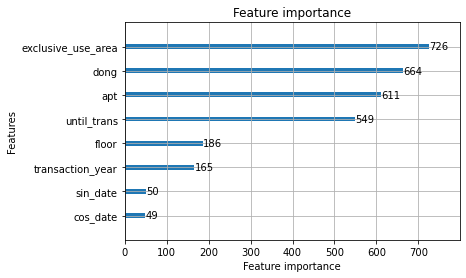

In [6]:
lgb.plot_importance(model)

exclusive_use_area 변수가 지니불순도를 가장 잘 줄였고, sin_date나 cos_date 변수가 가장 지니불순도를 잘 줄이지 못했다.

### 1.3 randomness Control

In [7]:
import random
import os
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

### 1.4 Permutation Feature Importance

In [9]:
from sklearn.inspection import permutation_importance

In [10]:
a = permutation_importance(best_lgbm_reg,test_cbe, test_y,random_state=42)

<ipython-input-36-1065b32d8471>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(test_cbe.columns[lgbm_importance_sorted_idx])


(0.0, 8.0)

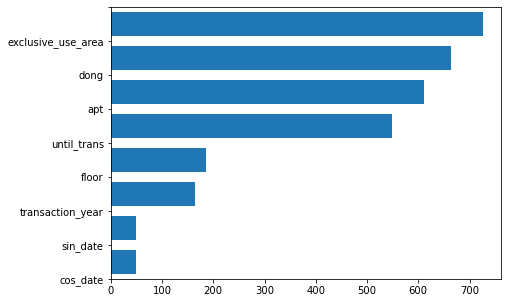

In [36]:
sorted_idx = a.importances_mean.argsort()

lgbm_importance_sorted_idx = np.argsort(best_lgbm_reg.feature_importances_)
lgbm_indices = np.arange(0, len(best_lgbm_reg.feature_importances_)) + 0.5

fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.barh(lgbm_indices,
         best_lgbm_reg.feature_importances_[lgbm_importance_sorted_idx], height=0.7)

#이름 설정하기
ax.set_yticklabels(test_cbe.columns[lgbm_importance_sorted_idx])
ax.set_ylim((0, len(best_lgbm_reg.feature_importances_)))

### 1.5 SHAP(SHapley Additive exPlanations)의 확인과 해석

In [37]:
! pip install shap

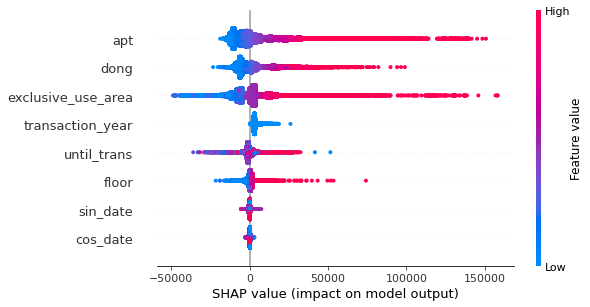

In [38]:
import shap
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(test_cbe)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0)).sort_values(ascending=False)
shap.summary_plot(shap_values, test_cbe)

apt, dong, exclusive_use_area, floor는 변수값이 클수록 예상 가격이 높은 경향성이 있다.

## 2. 딥러닝 기본

### 2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.

In [43]:
! pip install tensorflow
! pip install keras

  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=4a3376ac2e47e879ca99bec976f788938dec4b17bc0119e0869bfccb9e7f1bc5
  Stored in directory: c:\users\bounc\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=e0b6fdd5d9fca256e6107181e1d6a7a6d12eb6640fa88c2d273b1c149c51115f
  Stored in directory: c:\users\bounc\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built wrapt termcolor
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
  Using cached tensorflow-2.4.1-cp38-cp38-win_amd64.whl (370.7 MB)


In [44]:
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [59]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam

In [46]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [47]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


입력층의 뉴런이 256개, 은닉층은 2개로, 각각 64개와 32개의 뉴런을 갖고 있다. 출력층의 뉴런은 1개이다.

### 2.2 training loss와 validation loss를 시각화하세요

In [48]:
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

Epoch 1/300
611/611 [==============================] - 3s 5ms/step - loss: 1271372774.0654 - mse: 1271372774.0654 - val_loss: 339058656.0000 - val_mse: 339058656.0000
Epoch 2/300
611/611 [==============================] - 1s 2ms/step - loss: 231447249.4379 - mse: 231447249.4379 - val_loss: 336959904.0000 - val_mse: 336959904.0000
Epoch 3/300
611/611 [==============================] - 1s 2ms/step - loss: 224577383.3203 - mse: 224577383.3203 - val_loss: 348709056.0000 - val_mse: 348709056.0000
Epoch 4/300
611/611 [==============================] - 1s 2ms/step - loss: 223071003.3987 - mse: 223071003.3987 - val_loss: 357150976.0000 - val_mse: 357150976.0000
Epoch 5/300
611/611 [==============================] - 2s 3ms/step - loss: 231045069.2549 - mse: 231045069.2549 - val_loss: 331162080.0000 - val_mse: 331162080.0000
Epoch 6/300
611/611 [==============================] - 2s 3ms/step - loss: 238296197.9608 - mse: 238296197.9608 - val_loss: 329361120.0000 - val_mse: 329361120.0000
Epoch 7/

611/611 [==============================] - 2s 3ms/step - loss: 191725932.6536 - mse: 191725932.6536 - val_loss: 330984064.0000 - val_mse: 330984064.0000
Epoch 51/300
611/611 [==============================] - 2s 3ms/step - loss: 194008550.4837 - mse: 194008550.4837 - val_loss: 313113344.0000 - val_mse: 313113344.0000
Epoch 52/300
611/611 [==============================] - 2s 3ms/step - loss: 194782037.5163 - mse: 194782037.5163 - val_loss: 365007328.0000 - val_mse: 365007328.0000
Epoch 53/300
611/611 [==============================] - 2s 3ms/step - loss: 196385186.2222 - mse: 196385186.2222 - val_loss: 387846304.0000 - val_mse: 387846304.0000
Epoch 54/300
611/611 [==============================] - 2s 3ms/step - loss: 198689890.9542 - mse: 198689890.9542 - val_loss: 359593984.0000 - val_mse: 359593984.0000
Epoch 55/300
611/611 [==============================] - 2s 3ms/step - loss: 187452560.1830 - mse: 187452560.1830 - val_loss: 274666240.0000 - val_mse: 274666240.0000
Epoch 56/300
611/

611/611 [==============================] - 2s 3ms/step - loss: 187244180.6536 - mse: 187244180.6536 - val_loss: 320897600.0000 - val_mse: 320897600.0000
Epoch 100/300
611/611 [==============================] - 2s 3ms/step - loss: 188732846.9020 - mse: 188732846.9020 - val_loss: 319480928.0000 - val_mse: 319480928.0000
Epoch 101/300
611/611 [==============================] - 2s 3ms/step - loss: 178095645.5686 - mse: 178095645.5686 - val_loss: 244158752.0000 - val_mse: 244158752.0000
Epoch 102/300
611/611 [==============================] - 2s 3ms/step - loss: 180307360.4183 - mse: 180307360.4183 - val_loss: 345058784.0000 - val_mse: 345058784.0000
Epoch 103/300
611/611 [==============================] - 2s 3ms/step - loss: 177745798.6405 - mse: 177745798.6405 - val_loss: 327056288.0000 - val_mse: 327056288.0000
Epoch 104/300
611/611 [==============================] - 2s 3ms/step - loss: 178565684.7320 - mse: 178565684.7320 - val_loss: 372506432.0000 - val_mse: 372506432.0000
Epoch 105/30

611/611 [==============================] - 2s 3ms/step - loss: 178750512.7843 - mse: 178750512.7843 - val_loss: 273340192.0000 - val_mse: 273340192.0000
Epoch 149/300
611/611 [==============================] - 2s 3ms/step - loss: 174619121.1765 - mse: 174619121.1765 - val_loss: 317460928.0000 - val_mse: 317460928.0000
Epoch 150/300
611/611 [==============================] - 2s 3ms/step - loss: 175736072.7059 - mse: 175736072.7059 - val_loss: 284535296.0000 - val_mse: 284535296.0000
Epoch 151/300
611/611 [==============================] - 2s 3ms/step - loss: 179037974.1961 - mse: 179037974.1961 - val_loss: 329673472.0000 - val_mse: 329673472.0000
Epoch 152/300
611/611 [==============================] - 2s 3ms/step - loss: 177032126.0915 - mse: 177032126.0915 - val_loss: 337944672.0000 - val_mse: 337944672.0000
Epoch 153/300
611/611 [==============================] - 2s 3ms/step - loss: 181350377.2810 - mse: 181350377.2810 - val_loss: 371186208.0000 - val_mse: 371186208.0000
Epoch 154/30

611/611 [==============================] - 2s 3ms/step - loss: 173527531.0588 - mse: 173527531.0588 - val_loss: 248164224.0000 - val_mse: 248164224.0000
Epoch 198/300
611/611 [==============================] - 2s 3ms/step - loss: 175412793.9869 - mse: 175412793.9869 - val_loss: 288307904.0000 - val_mse: 288307904.0000
Epoch 199/300
611/611 [==============================] - 2s 3ms/step - loss: 170829070.9281 - mse: 170829070.9281 - val_loss: 256959440.0000 - val_mse: 256959440.0000
Epoch 200/300
611/611 [==============================] - 2s 3ms/step - loss: 169328153.6993 - mse: 169328153.6993 - val_loss: 280295040.0000 - val_mse: 280295040.0000
Epoch 201/300
611/611 [==============================] - 2s 3ms/step - loss: 173054291.1373 - mse: 173054291.1373 - val_loss: 249007280.0000 - val_mse: 249007280.0000
Epoch 202/300
611/611 [==============================] - 2s 3ms/step - loss: 171957028.8105 - mse: 171957028.8105 - val_loss: 262104688.0000 - val_mse: 262104688.0000
Epoch 203/30

611/611 [==============================] - 2s 3ms/step - loss: 160370315.5817 - mse: 160370315.5817 - val_loss: 246171568.0000 - val_mse: 246171568.0000
Epoch 247/300
611/611 [==============================] - 2s 3ms/step - loss: 168089183.3203 - mse: 168089183.3203 - val_loss: 221082208.0000 - val_mse: 221082208.0000
Epoch 248/300
611/611 [==============================] - 2s 3ms/step - loss: 172186744.6013 - mse: 172186744.6013 - val_loss: 282230976.0000 - val_mse: 282230976.0000
Epoch 249/300
611/611 [==============================] - 2s 3ms/step - loss: 163477371.2549 - mse: 163477371.2549 - val_loss: 271051520.0000 - val_mse: 271051520.0000
Epoch 250/300
611/611 [==============================] - 2s 3ms/step - loss: 171573564.2876 - mse: 171573564.2876 - val_loss: 257969920.0000 - val_mse: 257969920.0000
Epoch 251/300
611/611 [==============================] - 2s 3ms/step - loss: 165098249.6340 - mse: 165098249.6340 - val_loss: 266667088.0000 - val_mse: 266667088.0000
Epoch 252/30

611/611 [==============================] - 2s 3ms/step - loss: 163085788.7843 - mse: 163085788.7843 - val_loss: 350183776.0000 - val_mse: 350183776.0000
Epoch 296/300
611/611 [==============================] - 2s 3ms/step - loss: 161473021.9739 - mse: 161473021.9739 - val_loss: 265183264.0000 - val_mse: 265183264.0000
Epoch 297/300
611/611 [==============================] - 2s 3ms/step - loss: 162367619.0065 - mse: 162367619.0065 - val_loss: 294017248.0000 - val_mse: 294017248.0000
Epoch 298/300
611/611 [==============================] - 2s 3ms/step - loss: 157119143.4379 - mse: 157119143.4379 - val_loss: 346779136.0000 - val_mse: 346779136.0000
Epoch 299/300
611/611 [==============================] - 2s 3ms/step - loss: 159068828.9542 - mse: 159068828.9542 - val_loss: 310527232.0000 - val_mse: 310527232.0000
Epoch 300/300
611/611 [==============================] - 2s 3ms/step - loss: 160604135.7386 - mse: 160604135.7386 - val_loss: 303683648.0000 - val_mse: 303683648.0000


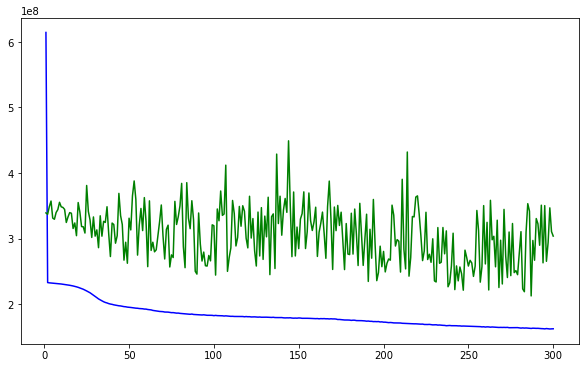

In [49]:
fig, ax = plt.subplots(figsize=(10,6))
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,301)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.show()

### 2.3 어떤 문제가 발생했는지 설명해주세요

딥러닝 이전보다 오히려 validation mse가 크게 증가했다.(거의 3-4배)  
오버피팅이 의심된다.

### 2.4 더 좋은 성능의 딥러닝 모델을 위해

In [50]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [64]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    Dropout(0.5),
    layers.Dense(32, activation='relu'),
    Dropout(0.5),
    layers.BatchNormalization(axis=1),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [65]:
history = model.fit(test_cbe,test_y, epochs=300, validation_data = (train_cbe,train_y), batch_size = 100000)

Epoch 1/300
1/1 [==============================] - 1s 528ms/step - loss: 542.5313 - mse: 542.5313 - val_loss: 3337251072.0000 - val_mse: 3337250816.0000
Epoch 2/300
1/1 [==============================] - 0s 443ms/step - loss: 557.1014 - mse: 557.1014 - val_loss: 3334928896.0000 - val_mse: 3334928896.0000
Epoch 3/300
1/1 [==============================] - 0s 452ms/step - loss: 543.4907 - mse: 543.4907 - val_loss: 3337264640.0000 - val_mse: 3337264640.0000
Epoch 4/300
1/1 [==============================] - 0s 461ms/step - loss: 553.2366 - mse: 553.2366 - val_loss: 3334919424.0000 - val_mse: 3334919424.0000
Epoch 5/300
1/1 [==============================] - 0s 450ms/step - loss: 544.8342 - mse: 544.8342 - val_loss: 3337247488.0000 - val_mse: 3337247488.0000
Epoch 6/300
1/1 [==============================] - 0s 446ms/step - loss: 562.9971 - mse: 562.9971 - val_loss: 3334937088.0000 - val_mse: 3334937088.0000
Epoch 7/300
1/1 [==============================] - 0s 446ms/step - loss: 541.7703 

1/1 [==============================] - 0s 450ms/step - loss: 560.6616 - mse: 560.6616 - val_loss: 3334939136.0000 - val_mse: 3334939136.0000
Epoch 55/300
1/1 [==============================] - 0s 437ms/step - loss: 541.6202 - mse: 541.6202 - val_loss: 3337261824.0000 - val_mse: 3337261824.0000
Epoch 56/300
1/1 [==============================] - 0s 444ms/step - loss: 555.9470 - mse: 555.9470 - val_loss: 3334920192.0000 - val_mse: 3334920192.0000
Epoch 57/300
1/1 [==============================] - 0s 444ms/step - loss: 543.3744 - mse: 543.3744 - val_loss: 3337237760.0000 - val_mse: 3337237760.0000
Epoch 58/300
1/1 [==============================] - 0s 456ms/step - loss: 558.2548 - mse: 558.2548 - val_loss: 3334945536.0000 - val_mse: 3334945536.0000
Epoch 59/300
1/1 [==============================] - 0s 455ms/step - loss: 538.4249 - mse: 538.4249 - val_loss: 3337251328.0000 - val_mse: 3337251328.0000
Epoch 60/300
1/1 [==============================] - 0s 438ms/step - loss: 549.8511 - mse:

1/1 [==============================] - 1s 511ms/step - loss: 536.7885 - mse: 536.7885 - val_loss: 3337242112.0000 - val_mse: 3337242112.0000
Epoch 108/300
1/1 [==============================] - 0s 462ms/step - loss: 545.5590 - mse: 545.5590 - val_loss: 3334930176.0000 - val_mse: 3334930176.0000
Epoch 109/300
1/1 [==============================] - 0s 473ms/step - loss: 541.4263 - mse: 541.4263 - val_loss: 3337253888.0000 - val_mse: 3337253888.0000
Epoch 110/300
1/1 [==============================] - 1s 511ms/step - loss: 558.9412 - mse: 558.9412 - val_loss: 3334927616.0000 - val_mse: 3334927616.0000
Epoch 111/300
1/1 [==============================] - 1s 511ms/step - loss: 542.5775 - mse: 542.5775 - val_loss: 3337266944.0000 - val_mse: 3337266944.0000
Epoch 112/300
1/1 [==============================] - 1s 516ms/step - loss: 559.8418 - mse: 559.8418 - val_loss: 3334919168.0000 - val_mse: 3334919168.0000
Epoch 113/300
1/1 [==============================] - 0s 485ms/step - loss: 542.5042 

Epoch 160/300
1/1 [==============================] - 1s 626ms/step - loss: 561.0772 - mse: 561.0772 - val_loss: 3334921472.0000 - val_mse: 3334921984.0000
Epoch 161/300
1/1 [==============================] - 1s 596ms/step - loss: 543.5281 - mse: 543.5281 - val_loss: 3337222400.0000 - val_mse: 3337222400.0000
Epoch 162/300
1/1 [==============================] - 1s 557ms/step - loss: 559.0745 - mse: 559.0745 - val_loss: 3334964480.0000 - val_mse: 3334964480.0000
Epoch 163/300
1/1 [==============================] - 1s 537ms/step - loss: 534.9913 - mse: 534.9913 - val_loss: 3337223936.0000 - val_mse: 3337223936.0000
Epoch 164/300
1/1 [==============================] - 1s 595ms/step - loss: 541.2939 - mse: 541.2939 - val_loss: 3334945536.0000 - val_mse: 3334945536.0000
Epoch 165/300
1/1 [==============================] - 1s 507ms/step - loss: 537.5598 - mse: 537.5598 - val_loss: 3337243136.0000 - val_mse: 3337243136.0000
Epoch 166/300
1/1 [==============================] - 0s 483ms/step - l

Epoch 213/300
1/1 [==============================] - 0s 489ms/step - loss: 542.1193 - mse: 542.1193 - val_loss: 3337247744.0000 - val_mse: 3337247744.0000
Epoch 214/300
1/1 [==============================] - 0s 498ms/step - loss: 559.9513 - mse: 559.9513 - val_loss: 3334932480.0000 - val_mse: 3334932480.0000
Epoch 215/300
1/1 [==============================] - 0s 491ms/step - loss: 541.4514 - mse: 541.4514 - val_loss: 3337264640.0000 - val_mse: 3337264640.0000
Epoch 216/300
1/1 [==============================] - 1s 516ms/step - loss: 550.1652 - mse: 550.1652 - val_loss: 3334923264.0000 - val_mse: 3334923264.0000
Epoch 217/300
1/1 [==============================] - 0s 488ms/step - loss: 541.7991 - mse: 541.7991 - val_loss: 3337245952.0000 - val_mse: 3337245952.0000
Epoch 218/300
1/1 [==============================] - 1s 502ms/step - loss: 556.4989 - mse: 556.4989 - val_loss: 3334943232.0000 - val_mse: 3334943232.0000
Epoch 219/300
1/1 [==============================] - 0s 488ms/step - l

Epoch 266/300
1/1 [==============================] - 0s 499ms/step - loss: 557.5426 - mse: 557.5426 - val_loss: 3334943232.0000 - val_mse: 3334943232.0000
Epoch 267/300
1/1 [==============================] - 0s 486ms/step - loss: 539.9537 - mse: 539.9537 - val_loss: 3337248256.0000 - val_mse: 3337248256.0000
Epoch 268/300
1/1 [==============================] - 1s 526ms/step - loss: 551.0047 - mse: 551.0047 - val_loss: 3334927104.0000 - val_mse: 3334927104.0000
Epoch 269/300
1/1 [==============================] - 1s 504ms/step - loss: 541.9293 - mse: 541.9293 - val_loss: 3337230592.0000 - val_mse: 3337230592.0000
Epoch 270/300
1/1 [==============================] - 0s 498ms/step - loss: 562.2033 - mse: 562.2033 - val_loss: 3334948608.0000 - val_mse: 3334948608.0000
Epoch 271/300
1/1 [==============================] - 1s 502ms/step - loss: 535.7676 - mse: 535.7676 - val_loss: 3337233152.0000 - val_mse: 3337233152.0000
Epoch 272/300
1/1 [==============================] - 1s 524ms/step - l

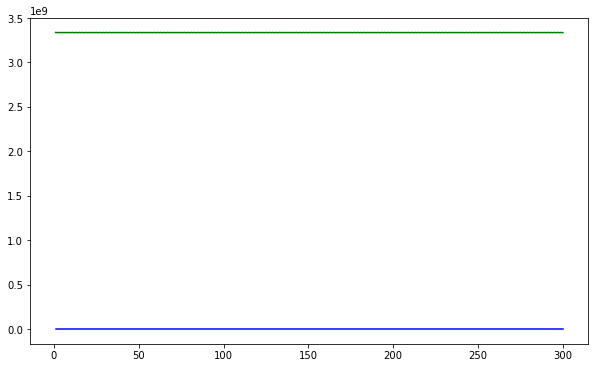

In [66]:
fig, ax = plt.subplots(figsize=(10,6))
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,301)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.show()

오버피팅을 줄이기 위해 나름 드룹아웃과 batch normalization을 시도해보았습니다.